In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, torch.cuda.get_device_name(0))

cuda:0 Tesla P4


In [4]:
DATA_PATH = Path('./data/')

In [5]:
train_loader, valid_loader, test_loader = mnist(batch_size=5000, valid=10000, path=DATA_PATH/'MNIST_data')

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-2, l2=0.):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 10)
        
        if batchnorm:
            self.bn1 = nn.BatchNorm1d(2048)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn1(x)
        
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.1)
        
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [7]:
def train(epoch, models, loader, log=None):
    train_size = len(loader.sampler)
    train_loss = defaultdict(float)
    train_correct = defaultdict(float)
    
    batches_num = len(loader)
    print_period = int(batches_num)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
            with torch.no_grad():
                train_loss[k] += model._loss.item() * len(data)
                pred = output.data.max(1, keepdim=True)[1]
                train_correct[k] += pred.eq(target.data.view_as(pred)).sum()
            
        if batch_idx % print_period == 0:
            items_processed = batch_idx * len(data)
            progress_pct = int(100. * batch_idx / batches_num)
            
            line = f'Train Epoch: {epoch} [{items_processed}/{train_size} ({progress_pct}%)]'
            losses = f'Losses ' + ' '.join([f'{k}: {model._loss.item():.6f}' for k, model in models.items()])
            print(line + '\t' + losses)        
    else:
        batch_idx += 1
        items_processed = batch_idx * len(data)
        progress_pct = int(100. * batch_idx / batches_num)
        line = f'Train Epoch: {epoch} [{items_processed}/{train_size} ({progress_pct}%)]'
        losses = 'Losses ' + ' '.join([f'{k}: {model._loss.item():.6f}' for k, model in models.items()])
        print(line + '\t' + losses)
        
        train_correct_pct = {k: 100. * train_correct[k] / train_size for k in train_correct}
        
        for k in models:
            train_loss[k] /= train_size
            
        if log is not None:
            for k in models:
                log[k].append((train_loss[k], train_correct_pct[k]))

In [8]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = defaultdict(float)
    test_correct = defaultdict(float)
    
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            
            for k, model in models.items():
                output = model(data)
                test_loss[k] += model.loss(output, target, reduction='sum').item()
                pred = output.data.max(1, keepdim=True)[1]
                test_correct[k] += pred.eq(target.data.view_as(pred)).sum()
    
    for k in models:
        test_loss[k] /= test_size
        
    test_correct_pct = {k: 100. * test_correct[k] / test_size for k in test_correct}
    
    lines = '\n'.join([f'{k}: Loss: {test_loss[k]:.4f} \t Accuracy: {test_correct[k]}/{test_size} ({test_correct_pct[k]:.0f})%' for k in models]) + '\n'
    report = 'Test set:\n' + lines

    if log is not None:
        for k in models:
            log[k].append((test_loss[k], test_correct_pct[k]))
            
    print(report)

In [9]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [10]:
def create_nn(model, device, *args):
    net = model(*args)
    net.apply(init_weights)
    net.to(device)
    return net

In [11]:
models = {'default': create_nn(Net, device, False, False), 
          'bn': create_nn(Net, device, True, False), 
          'drop': create_nn(Net, device, False, True), 
          'both': create_nn(Net, device, True, True)}

train_log = defaultdict(list)
test_log = defaultdict(list)

for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models, train_loader, train_log)
    
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 3.465428 bn: 2.560254 drop: 3.164496 both: 2.655546
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 1.244750 bn: 0.513403 drop: 0.682095 both: 0.460998
Test set:
default: Loss: 0.9995 	 Accuracy: 7023/10000 (70)%
bn: Loss: 3.2973 	 Accuracy: 6582/10000 (65)%
drop: Loss: 0.6163 	 Accuracy: 8145/10000 (81)%
both: Loss: 3.3557 	 Accuracy: 6215/10000 (62)%

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.981537 bn: 0.438532 drop: 0.594942 both: 0.389025
Train Epoch: 2 [50000/50000 (100%)]	Losses default: 0.408372 bn: 0.199565 drop: 0.293644 both: 0.194869
Test set:
default: Loss: 0.4016 	 Accuracy: 8895/10000 (88)%
bn: Loss: 0.4059 	 Accuracy: 9164/10000 (91)%
drop: Loss: 0.2794 	 Accuracy: 9163/10000 (91)%
both: Loss: 0.3605 	 Accuracy: 9228/10000 (92)%

Train Epoch: 3 [0/50000 (0%)]	Losses default: 0.349700 bn: 0.158695 drop: 0.249639 both: 0.160461
Train Epoch: 3 [50000/50000 (100%)]	Losses default: 0.248667 bn: 0.129571 drop: 0.195934 b

In [13]:
with open(DATA_PATH/'train_log.pkl', 'rb') as f:
    train_log = pickle.load(f)
with open(DATA_PATH/'test_log.pkl', 'rb') as f:
    test_log = pickle.load(f)

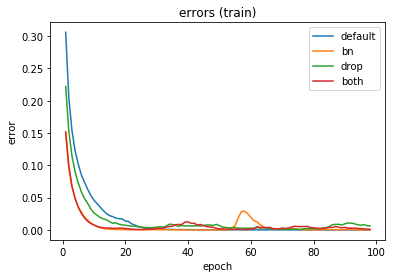

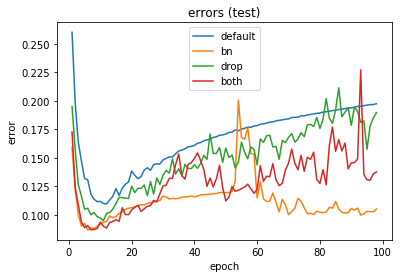

In [50]:
plot_graphs(train_log, 'loss', start_epoch=3, title='train')
plot_graphs(test_log, 'loss', start_epoch=3, title='test')

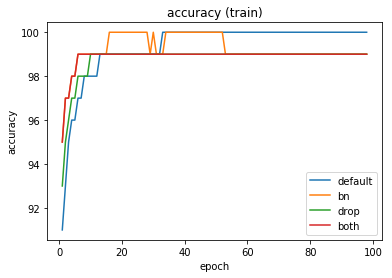

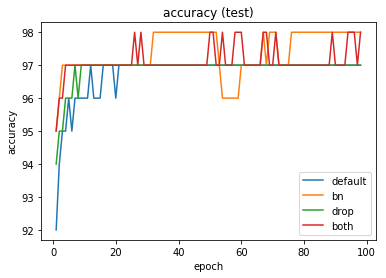

In [51]:
plot_graphs(train_log, 'accuracy', start_epoch=3, title='train')
plot_graphs(test_log, 'accuracy', start_epoch=3, title='test')